In [1]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Setup

Data: the responses collected from a previous survery of the COGS 108 class. 
- There are 416 observations in the data, covering 10 different 'features'.

Research Question: Do students in different majors have different heights?

Background: Physical height has previously shown to correlate with career choice, and career success. More recently it has been demonstrated that these correlations can actually be explained by height in high school, as opposed to height in adulthood (1). It is currently unclear whether height correlates with choice of major in university. 

Reference: 1) https://www.sas.upenn.edu/~apostlew/paper/pdf/short.pdf

Hypothesis: We hypothesize that there will be a relation between height and chosen major. 

In [2]:
# your code here
df = pd.read_csv('COGS108_IntroQuestionnaireData.csv')
df.shape


(416, 10)

Let's checkout the data: 

In [3]:
df.head(5)

,Timestamp,What year (in school) are you?,What is your major?,How old are you?,What is your gender?,What is your height?,What is your weight?,What is your eye color?,Were you born in California?,What is your favorite flavor of ice cream?
0,1/9/18 14:49,4,Cognitive Science,21.0,Male,"5'8""",147,Brown,Yes,Vanilla
1,1/9/18 14:49,3,Cognitive Science,20.0,Male,5'8,150,Brown,Yes,Cookies and Cream
2,1/9/18 14:49,Third,Computer Science,21.0,Male,181cm,74kg,Black,Yes,Matcha
3,1/9/18 14:49,2,Cogs HCI,20.0,Male,5’8,133,Brown,Yes,Cookies and Cream
4,1/9/18 14:49,3,Computer Science,20.0,Male,"5'10""",160,Brown,Yes,Cookies n' Cream


In [4]:
# Renaming the columns of the dataframe
df.columns = ['timestamp', 'year', 'major', 'age', 'gender', 'height',
              'weight', 'eye_color', 'born_in_CA', 'favorite_icecream']

In [5]:
df.isnull().head(5)

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [6]:
rows_to_drop = df[df.isnull().any(axis=1)]
rows_to_drop.shape

(31, 10)

In [7]:
rows_to_drop

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
21,1/9/18 14:49,1,Cse,16.0,Male,184cm,78kg,Black,No,NaN
29,1/9/18 14:50,senior,math&econ,20.0,female,170,130,black,No,NaN
38,1/9/18 14:50,3rd,Computer Engineering,21.0,Female,NaN,NaN,Brown,No,NaN
49,1/9/18 14:50,NaN,Cog Sci,21.0,Female,NaN,NaN,Brown,Yes,Chocolate
58,1/9/18 14:50,3rd,Computer Science,20.0,Female,5ft 2in,NaN,brown,No,cookies and cream
66,1/9/18 14:50,Sophomore,Cognitive Science - Design and Interaction,19.0,Female,5'5,NaN,Brown,No,Chubby hubby ben and jerrys
67,1/9/18 14:50,2,Computer Science,19.0,Male,NaN,170,Brown,Yes,Chocolate
83,1/9/18 14:50,Senior,Computer Science,22.0,Male,5'11,155 lb,dark brown,No,NaN
91,1/9/18 14:50,Third,Computer Science,21.0,Female,NaN,NaN,Black,No,Green tea
92,1/9/18 14:50,4,Computer Science,21.0,Female,"5'5""",NaN,Brown,Yes,Mint chip


In [8]:
df = df.dropna(subset=['major', 'height', 'gender', 'age']) #how = 'any', inplace = True)
df.shape

(403, 10)

In [9]:
def example_standardize_function(str_in):
    '''Standardize data to the question 'what is your favorite major python version?'
    
    Parameters
    ----------
    str_in : string
        A provided answer.
        
    Returns
    -------
    int_out : int or np.nan
        A standardized integer response.
    '''
    
    # Make the input all lowercase
    str_in = str_in.lower()
    
    # Drop all whitespace
    str_in = str_in.strip()
    
    # Replace things (and then strip again afterwords)
    # Note that the 'replace' replaces the first argument, with the second
    # The first argument does not need to be present in the string,
    # if it's not there 'replace' does nothing (but does not error), so the code moves on.
    str_in = str_in.replace('version', '')
    str_in = str_in.replace('python', '')
    str_in = str_in.strip()
    
    # Cast to integer, if what's left seems appropriate
    if str_in.isnumeric() and len(str_in) == 1:
        out = int(str_in)
    # Otherwise, consider input was probably ill-formed, return nan
    else: 
        out = np.nan
    
    return out

# Check how this function help standardize data:
# Example possible answers to the question 'What is your favourite major version of Python':
print('INPUT', '\t\t-\t', 'OUTPUT')
for inp in ['version 3', '42', '2', 'python 3', 'nonsense-lolz']:
    print('{:10s} \t-\t {:1.0f}'.format(inp, example_standardize_function(inp)))

INPUT 		-	 OUTPUT
version 3  	-	 3
42         	-	 nan
2          	-	 2
python 3   	-	 3
nonsense-lolz 	-	 nan


Below, we can observe the majors: 

In [10]:
df['major'].unique()

array(['Cognitive Science', 'Computer Science', 'Cogs HCI',
       'Cognitive Science w/ a specialization in Computation',
       'International Studies', 'Computer Engineering',
       'computer science', 'Chemical Engineering / Literature Writing',
       'Cognitive Science w/ Specialization in Human Computer Interaction',
       'Cognitive Science-- Machine Learning and Neural Computation ',
       'Cse', 'Cognitive Science - Design and Interaction',
       'cognitive science', 'CSE', 'Cog sci design interaction',
       'Math CS', 'Electrical Engineering', 'math&econ',
       'Cognitive Science spec/ HCI', 'Cognitive science', 'Math-CS',
       'Data Science', 'Cognitive science ', 'Cognitive Science ',
       'Math - CS ', 'Cognitive Science Human Computer Interaction',
       'Cognitive Science with specialization in HCI ',
       'Cognitive Science (HCI)', 'Probability & Statistics', 'Cog Sci',
       'Cognitive Science - Machine Learning',
       'Mathematics-computer science',

In [11]:
def standardize_major(string):
    
    string = string.lower()
    string = string.strip()
    
    if 'cog' in string:
        output = 'COGSCI'
    elif 'computer' in string:
        output = 'COMPSCI'
    elif 'cs' in string:
        output = 'COMPSCI'
    elif 'math' in string:
        output = 'MATH'
    elif 'electrical' in string:
        output = 'ECE'
    elif 'bio' in string:
        output = 'BIO'
    elif 'chem' in string:
        output = 'CHEM'
        
    # Otherwise, if uncaught - keep as is
    else:
        output = string
    
    return output

In [12]:
df['major'] = df['major'].apply(standardize_major)

In [13]:
df['major'].unique()

array(['COGSCI', 'COMPSCI', 'international studies', 'CHEM', 'ECE',
       'MATH', 'data science', 'political science', 'BIO', 'psychology',
       'physiology and neuroscience', 'management science',
       'interdisciplinary computing & the arts', 'machine learning',
       'neuroscience'], dtype=object)

Now, we want to standarize gender responses: 

In [14]:
df['gender'].value_counts()

gender
Male           229
Female          95
female          26
male            18
F               10
M                6
Female           6
Male             6
Famale           1
men              1
MALE             1
Rainbow          1
Woman            1
Transgender      1
Nonbinary        1
Name: count, dtype: int64

In [15]:
def standardize_gender(gender):
    
    print(gender)
    string = gender
    # Make the input all lowercase
    string = string.lower()
    

    string = string.strip()
    
    if 'female' in string:
        output = 'female'
    elif 'f' in string:
        output = 'female'
    elif 'woman' in string:
        output = 'female'
    elif 'famale' in string:
        output = 'female'
    elif 'women' in string:
        output = 'female'
    elif 'male' in string:
        output = 'male'
    elif 'm' in string:
        output = 'male'
    elif 'man' in string:
        output = 'male'
    elif 'men' in string:
        output = 'male'
    elif 'nonbinary' in string:
        output = 'nonbinary_or_trans'
    elif 'transgender' in string:
        output = 'nonbinary_or_trans'
    # Otherwise, if uncaught - keep as is
    else:
        output = np.nan
    
    return output

In [16]:
#df['gender']
df['gender'] = df['gender'].apply(standardize_gender)
df = df.dropna(subset = ['gender'])

Male
Male
Male
Male
Male
Male
Male
Female
Male
Male
Male
Female
male
Female
Male
Female
M
Male
Male
F
Female 
Male
Female
Male
male
Male
male
Female
Male
female
Male
Male
Female
Male
Male
female
Female
Male
Male
Male
Female
Male
Female
Famale
Male
Female
Female
Male
Female
Male
Male 
Female
Male
Male
Female
Male
Female
Female
Male
Male
Male
Male
Male
Female
Female
Male
Male
female
Male
Male
Female
Male
female
Male
female
Female
Female
Female
Female
Male
Male
male
Male
Male
Female
Male
Male 
Female
Female
Male
Male
Female
Male
Female
Male
male
Female
F
Male
male
Female
Male
Male 
Male
Male
F
female
Male
Male
Female
Male
Male
Male
F
Male
Female
Male
Male
male
Female
female
Male
Male 
Male
Female
female
Female
Male
Male
Male
Male
Female
Female
Female
Male
Female
Male
Female
Female
Male
Male
Male
Female
Male
Male
Male
Male
Male
female
men 
Male
M
Male
Female
Male
Male
Male
Male
Male
female
female
female
Male
Male
Male
Female
Male
female
Female
Male
Male
Female
Male
Male
Female
Male
Male
Ma

In [17]:
df['gender'].unique()

array(['male', 'female', 'nonbinary_or_trans'], dtype=object)

In the data, there is a number of unique responses in the 'year' column:

In [18]:
num_unique_responses = df['year'].nunique()
num_unique_responses

63

In [19]:
df['year'].unique()

array(['4', '3', 'Third', '2', '3rd', '3rd year', '5th', 'Second',
       '4th Year', '5', 'Senior', 'Junior', '2nd', '1', 'senior', 'third',
       'first year', '4th', 'Yolanda', 'Junior ', 'Freshman', 'Sophomore',
       '4th year', '6', 'second year', 'Third Year', '2nd year', 'First',
       '5th (2nd year transfer)', '2018', 'last year', 'UCSD',
       'Fifth Year', '2021', 'Fifth year', '3rd Year', '3rd year ',
       'Second year', 'fourth year', 'First year', 'Sophmore',
       'Second Year', 'Junior year', '2020', 'Fifth ', 'Sophomore ',
       '2nd year ', '4th year ', '2nd Year', '4+', 'second', 'Fourth',
       'Senior Year', '2nd (Sophomore)', 'Sixth', 'Senior ', ' 3rd Year',
       'Fourth Year', 'Junior standing', 'Fourth year', 'Fifth',
       'Third year', 'Sineor '], dtype=object)

Now, we can standarize the year column: 

In [20]:
#START CODE 
def standardize_year(string):
    
    # Make the input all lowercase
    string = string.lower()
    
    # Drop all whitespace
    string = string.strip()
    
    #replace any occurences of 'first' with '1'
    string = string.replace('first', '1')

    #replace any occurences of 'second' with '2'
    string = string.replace('second', '2')    

    #replace any occurences of 'third' with '3'
    string = string.replace('third', '3')    

    #replace any occurences of 'fourth' with '4'
    string = string.replace('fourth', '4')    

    
    #replace any occurences of 'fifth' with '5'
    string = string.replace('fifth', '5')  

    #replace any occurences of 'sixth' with '6'
    string = string.replace('sixth', '6')    

    #replace any occurences of 'freshman' with '1'
    string = string.replace('freshman', '1')    

    #replace any occurences of 'sophomore' with '2'
    string = string.replace('sophomore', '2')    

    #replace any occurences of 'junior' with '3'
    string = string.replace('junior', '3')    

    #replace any occurences of 'senior' with 4'
    string = string.replace('senior', '4')    

    #replace any occurences of 'year' with '' (remove it from the string)
    string = string.replace('year', '')    

    #replace any occurences of 'th' with '' (remove it from the string)
    string = string.replace('th', '')    

    #replace any occurences of 'rd' with '' (remove it from the string)
    string = string.replace('rd', '')    

    #replace any occurences of 'nd' with '' (remove it from the string)
    string = string.replace('nd', '')    

    #strip the string of all leading and trailing whitespace (again)
    string = string.strip()

    #If the resulting string is a number and it is less than 10, then cast it into an integer and return that value
    # Cast to integer, if what's left seems appropriate
    if string.isnumeric() and int(string) < 10:
        out_put = int(string)
        
    #Else return np.nan to symbolize that the student's response was not a valid entry
    else:
        out_put = np.nan
    
    return out_put
#END CODE 

In [21]:
df['year'].unique()

array(['4', '3', 'Third', '2', '3rd', '3rd year', '5th', 'Second',
       '4th Year', '5', 'Senior', 'Junior', '2nd', '1', 'senior', 'third',
       'first year', '4th', 'Yolanda', 'Junior ', 'Freshman', 'Sophomore',
       '4th year', '6', 'second year', 'Third Year', '2nd year', 'First',
       '5th (2nd year transfer)', '2018', 'last year', 'UCSD',
       'Fifth Year', '2021', 'Fifth year', '3rd Year', '3rd year ',
       'Second year', 'fourth year', 'First year', 'Sophmore',
       'Second Year', 'Junior year', '2020', 'Fifth ', 'Sophomore ',
       '2nd year ', '4th year ', '2nd Year', '4+', 'second', 'Fourth',
       'Senior Year', '2nd (Sophomore)', 'Sixth', 'Senior ', ' 3rd Year',
       'Fourth Year', 'Junior standing', 'Fourth year', 'Fifth',
       'Third year', 'Sineor '], dtype=object)

In [22]:
df['year'] = df['year'].apply(standardize_year)

What about weight? I can also standarize that column: 

In [23]:
df['weight'] = df['weight'].astype(str)

In [24]:
df['weight'].unique()

array(['147', '150', '74kg', '133', '160', '106 lb', '155', '170 pounds',
       '170', '135', '115', '110', '167 lbs', '60kg', '136', '140', '120',
       '78kg', '128 lbs', '220', '145lb', '180', '105', '160lbs', '130',
       '177g', '125 pounds', '125', '210', '69kg', '165', '160 lbs',
       '123', '135lbs', '112 pounds', '190', '145lbs', '150 lbs', 'nan',
       '193lbs', '73kg', '133 lb', '107 pounds', '200', '240', '47kg',
       '175', '120 lbs', '164', '110 lbs', '128lbs', '155 lb', '185',
       '167', '84 kg', '113', '235', '128lb', '119 lbs', '110 lb', '72kg',
       '122', '140 lbs', '70 kg', '165 pounds ', '128', '125 lb', '108',
       '15', '215', '48kg', '52kg', '145', '185lbs. ', '230lb', '125 lbs',
       '140 lb', '168lb', '100', '130 pounds', '124', '84kg', '119',
       "I don't know dude but heavy probably", '103', '140lbs', '170lbs',
       '155 lbs', '50kg', '190 lbs', '52 kg', '168lbs', '189', '168',
       '76KG', '77kg', '181', '146', '156', '140 pounds', '

In [25]:
def standardize_weight(string):
    
    #convert all characters of the string into lowercase
    string = string.lower()
    
    #strip the string of all leading and trailing whitespace
    string = string.strip()

    #replace any occurences of 'lbs' with '' (remove it from the string)
    string = string.replace('lbs', '')    

    #replace any occurences of 'lb' with '' (remove it from the string)
    string = string.replace('lb', '')    
    
    #replace any occurences of 'pounds' with '' (remove it from the string)
    string = string.replace('pounds', '')    

    if 'kg' in string:
        string = string.replace('kg', '')
        #strip the string of all leading and trailing whitespace
        string = string.strip()
        
        #can keep string 
        string = float(string)
        string = string * 2.2
    try: 
        return int(string)
    except:
        return np.nan

In [26]:
df['weight'] = df['weight'].apply(standardize_weight)

In [27]:
df['weight'].unique()

array([147., 150., 162., 133., 160., 106., 155., 170., 135., 115., 110.,
       167., 132., 136., 140., 120., 171., 128., 220., 145., 180., 105.,
       130.,  nan, 125., 210., 151., 165., 123., 112., 190., 193., 107.,
       200., 240., 103., 175., 164., 185., 184., 113., 235., 119., 158.,
       122., 154., 108.,  15., 215., 114., 230., 168., 100., 124., 189.,
       169., 181., 146., 156., 101., 250., 127., 173., 134., 102., 320.,
       142., 280., 209.,  58., 129., 187., 152., 138., 141.,  98., 205.,
       300.,  99., 179., 116.,  75.,  85.])

Finall, the last column I want to standarize is height: 

In [28]:
# convert all values to inches
def standardize_height(string):
    
    orig = string
    output = None
    
    # Basic string pre-processing
    string = string.lower()
    string = string.strip()
    
    string = string.replace('foot', 'ft')
    string = string.replace('feet', 'ft')
    string = string.replace('inches', 'in')
    string = string.replace('inch', 'in')
    string = string.replace('meters', 'm')
    string = string.replace('meter', 'm')
    string = string.replace('centimeters', 'cm')
    string = string.replace('centimeter', 'cm')
    string = string.replace(',', '')
    string = string.strip()
    
    # CASE 1: string is written in the format FEET <DIVIDER> INCHES
    dividers = ["'", "ft", "’", '”', '"','`', "-", "''"]
    
    for divider in dividers:
        
        # Split it into its elements
        elements = string.split(divider)

        # If the divider creates two elements
        if (len(elements) >= 2) and ((len(string) -1) != string.find(divider)):
            feet = elements[0]
            inch = elements[1] if elements[1] is not '' else '0'
            
            # Cleaning extranious symbols
            for symbol in dividers:
                feet = feet.replace(symbol, '')
                inch = inch.replace(symbol, '')
                inch = inch.replace('in','')
            
            # Removing whitespace
            feet = feet.strip()
            inch = inch.strip()
            
            # By this point, we expect 'feet' and 'inch' to be numeric
            # If not...we ignore this case
            if feet.replace('.', '').isnumeric() and inch.replace('.', '').isnumeric():
                
                # Converting feet to inches and adding it to the current inches
                output = (float(feet) * 12) + float(inch)
                break
            
    # CASE 2: string is written in the format FEET ft INCHES in 
    if ('ft' in string) and ('in' in string):
        
        # Split it into its elements
        elements = string.split('ft')
        feet = elements[0]
        inch = elements[1]
        
        # Removing extraneous symbols and stripping whitespace
        inch = inch.replace('inch', '')
        inch = inch.replace('in', '')
        feet = feet.strip()
        inch = inch.strip()
        
        # By this point, we expect 'feet' and 'inch' to be numeric
        # If not...we ignore this case
        if feet.replace('.', '').isnumeric() and inch.replace('.', '').isnumeric():
                
            # Converting feet to inches and adding it to the current inches
            output = (float(feet) * 12) + float(inch)
        
    # CASE 3: answer was given ONLY in cm
    #  Convert to inches: approximately 0.39 inches in a meter
    elif 'cm' in string:
        centimeters = string.replace('cm', '')
        centimeters = centimeters.strip()
        
        if centimeters.replace('.', '').isnumeric():
            output = float(centimeters) * 0.39
        
    # CASE 4: answer was given ONLY in meters
    #  Convert to inches: approximately 39 inches in a meter
    elif 'm' in string:
        
        meters = string.replace('m', '')
        meters = meters.strip()
        
        if meters.replace('.', '').isnumeric():
            output = float(meters)*39
        
    # CASE 5: answer was given ONLY in feet
    elif 'ft' in string:

        feet = string.replace('ft', '')
        feet = feet.strip()
        
        if feet.replace('.', '').isnumeric():
            output = float(feet)*12
    
    # CASE 6: answer was given ONLY in inches
    elif 'in' in string:
        inches = string.replace('in', '')
        inches = inches.strip()
        
        if inches.replace('.', '').isnumeric():
            output = float(inches)
        
    # CASE 7: answer not covered by existing scenarios / was invalid. 
    #  Return NaN
    if not output:
        output = np.nan

    return output

In [29]:
# Applying the transformation and dropping invalid rows
df['height'] = df['height'].apply(standardize_height)
df = df.dropna(subset=['height'])

In [30]:
df['height'].unique()

array([68.  , 70.59, 70.  , 71.  , 69.  , 63.  , 70.2 , 62.  , 65.  ,
       61.62, 67.  , 71.76, 74.  , 73.  , 64.  , 69.03, 66.  , 66.69,
       72.  , 67.47, 60.  , 62.4 , 61.  , 76.  , 68.5 , 69.42, 67.86,
       65.13, 65.52, 63.57, 67.08, 66.3 , 74.1 , 62.79, 75.  , 63.18,
       72.15, 68.64, 69.81, 63.96, 59.  , 68.25, 66.5 , 73.5 , 72.54,
       63.75, 58.  ])

In [31]:
df['age'] = df['age'].astype(np.int64)
df['age']

0      21
1      20
2      21
3      20
4      20
       ..
411    29
412    20
413    28
414    23
415    21
Name: age, Length: 365, dtype: int64

# EDA

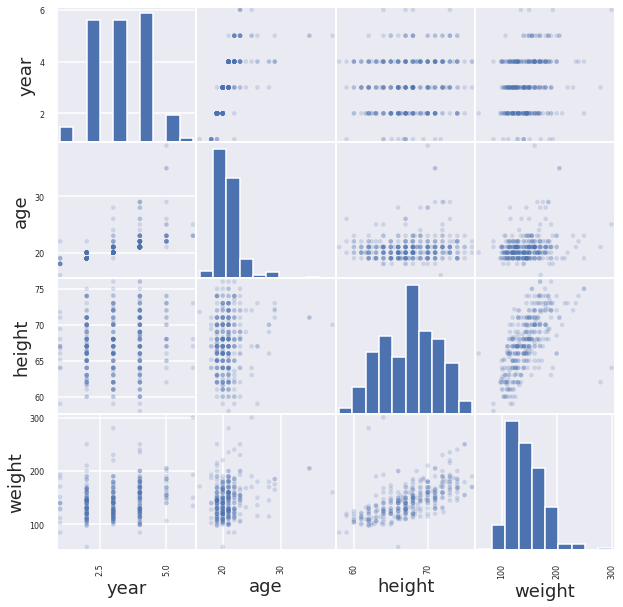

In [32]:
fig = pd.plotting.scatter_matrix(df, alpha=0.2, figsize = (10,10))

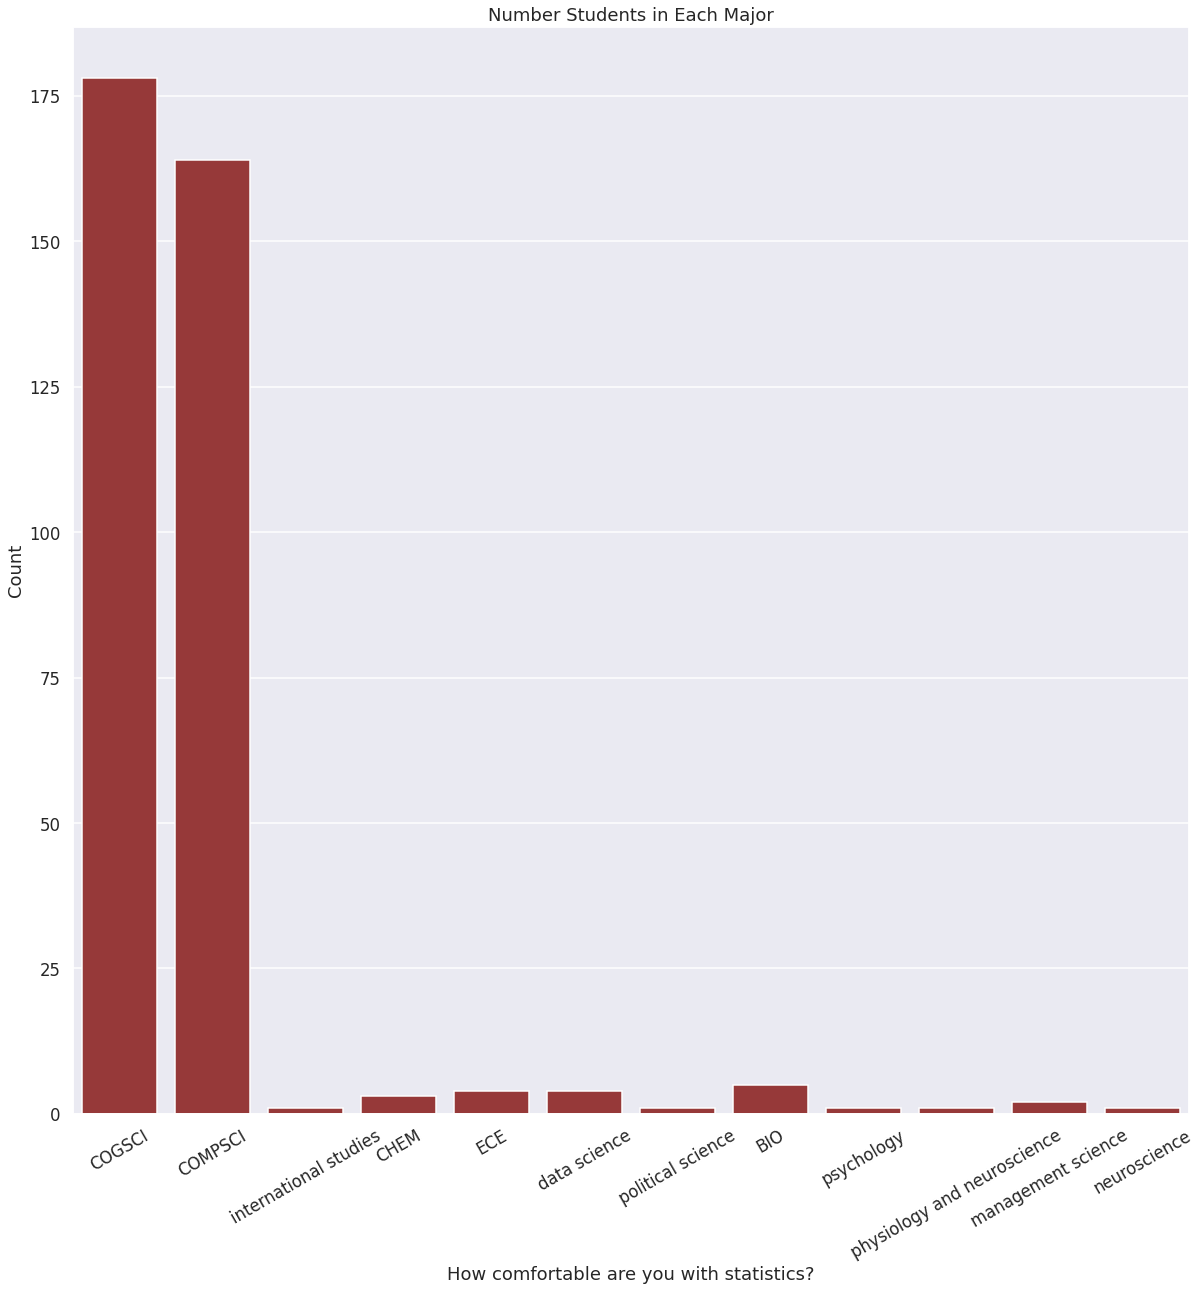

In [33]:
plt.rcParams['figure.figsize'] = (20,20)
ax = sns.countplot(x='major', data=df, color = 'brown')

#add title: 
ax.set_title('Number Students in Each Major')
#add y label 
ax.set_ylabel('Count')
#add x label 
ax.set_xlabel('How comfortable are you with statistics?');
ax.tick_params(axis='x', rotation=30)

f1 = plt.gcf()

Below, I can also see a histogram of data responses from the dataframe: 

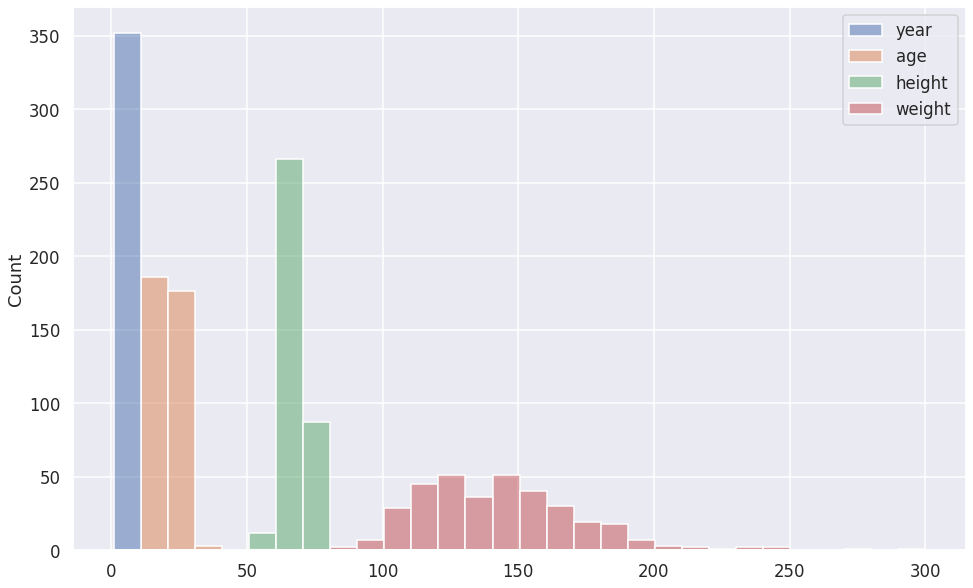

In [34]:
plt.rcParams['figure.figsize'] = (16,10) #default plot size to output
sns.histplot(data = df, bins=30)
f2 = plt.gcf()

What's the range of ages in the dataset? 

In [35]:
r_age = df['age'].max() - df['age'].min()
print("The range of ages in the dataset are: ", r_age)

The range of ages in the dataset are:  23


Lets save the height data for both cognitive science and computer science majors:

In [36]:
h_co = df[(df.major == 'COGSCI')]['height']
h_cs = df[(df.major == 'COMPSCI')]['height']

In [37]:
h_co.describe()

count    178.000000
mean      66.813146
std        4.088307
min       58.000000
25%       64.000000
50%       67.000000
75%       70.000000
max       76.000000
Name: height, dtype: float64

In [38]:
h_cs.describe()

count    164.000000
mean      68.208659
std        3.487825
min       61.000000
25%       66.000000
50%       68.000000
75%       71.000000
max       76.000000
Name: height, dtype: float64

In [39]:
avg_h_co = h_co.agg('mean')
avg_h_co

66.81314606741573

In [40]:
avg_h_cs = h_cs.agg('mean')
avg_h_cs

68.20865853658538

In [41]:
print('Average height of cogs majors is \t {:2.2f} inches'.format(avg_h_co))
print('Average height of cs majors is \t\t {:2.2f} inches'.format(avg_h_cs))

Average height of cogs majors is 	 66.81 inches
Average height of cs majors is 		 68.21 inches


I want to use the `ttest_ind` function) to compare the two height distributions (`h_co` vs `h_cs`)

`ttest_ind` returns a t-statistic, and a p-value. Save these outputs to `t_val` and `p_val` respectively. 

In [42]:
t_val, p_val = stats.ttest_ind(h_co, h_cs)

In [43]:
if p_val < 0.01:
    print('Data Science accomplished, there is a significant difference!')
else:
    print('There is NOT a significant difference!')

Data Science accomplished, there is a significant difference!


#Save the counts for each gender for 'COGSCI' amd 'OCMPSCI' majors: 

In [44]:
#Save the counts for each gender for 'COGSCI' majors to a variable called g_co
g_co = df[(df.major == 'COGSCI')]['gender'].value_counts()
#Save the counts for each gender for 'COMPSCI' majors to a variable called g_cs
g_cs = df[(df.major == 'COMPSCI')]['gender'].value_counts()

Ratio of women in Cognitive Science and Computer Science majors:

In [45]:
r_co = g_co['female']
r_cs = g_cs['female']
print(r_co,r_cs )

86 38


In [46]:
chisq, p_val_chi = stats.chisquare(np.array([g_co.values, g_cs.values]), axis=None)

if p_val_chi < 0.01:
    print('There is a significant difference in ratios!')

There is a significant difference in ratios!


Now I want to create a linear model which predicts height from majors. To do this I created a new dataframe containing only the majors of cognitive and computer science

In [47]:
df2 = df[(df['major'] == 'COGSCI') | (df['major'] == 'COMPSCI')]

In [48]:
df2

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
0,1/9/18 14:49,4.0,COGSCI,21,male,68.00,147.0,Brown,Yes,Vanilla
1,1/9/18 14:49,3.0,COGSCI,20,male,68.00,150.0,Brown,Yes,Cookies and Cream
2,1/9/18 14:49,3.0,COMPSCI,21,male,70.59,162.0,Black,Yes,Matcha
3,1/9/18 14:49,2.0,COGSCI,20,male,68.00,133.0,Brown,Yes,Cookies and Cream
4,1/9/18 14:49,3.0,COMPSCI,20,male,70.00,160.0,Brown,Yes,Cookies n' Cream
...,...,...,...,...,...,...,...,...,...,...
410,1/9/18 14:54,3.0,COMPSCI,20,female,65.00,125.0,Brown,No,Sea salt caramel
411,1/9/18 14:54,4.0,COGSCI,29,male,72.15,185.0,Brown,No,Cookies and Cream
412,1/9/18 14:55,3.0,COMPSCI,20,male,71.00,NaN,Brown,Yes,NaN
413,1/9/18 14:55,NaN,COMPSCI,28,male,69.00,170.0,Brown,No,Chocolate


In [49]:
#create the design matrices 
outcome_1, predictors_1 = patsy.dmatrices('height ~ major', df2)
#create the OLS model 
mod_1 = sm.OLS(outcome_1, predictors_1)
#fit the model 
res_1 = mod_1.fit()

In [50]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     11.44
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           0.000803
Time:                        23:30:45   Log-Likelihood:                -941.95
No. Observations:                 342   AIC:                             1888.
Df Residuals:                     340   BIC:                             1896.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           66.8131      0.286  